In [1]:
# append parent to path to allow imports
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [2]:
from pathlib import Path
import cv2
import numpy as np

from src.face import FaceDetector
from src.mask import MaskHandler
from src.utils.project_utils import Utils
from src.region import Region, Phi_N, SuperpixelProbability
from src.superpixels import SuperpixelExtractor
from src.feature import Feature, FeatureExtractor, FeatureDivergence, EFeature

In [3]:
fd = FaceDetector("../assets/lbfmodel.yaml")
mh = MaskHandler()

IMAGE_PATH = Path("test_images/britney_spears.jpg")

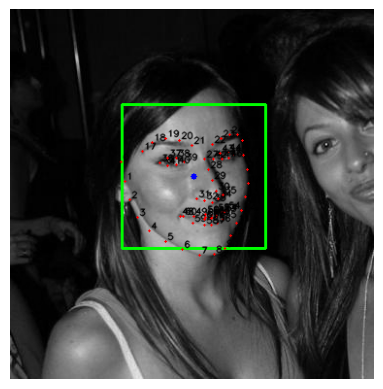

In [4]:
img_rgb, _, _, landmarks_all_faces = fd.detect(IMAGE_PATH, display_indices=True)
Utils.display(img_rgb)

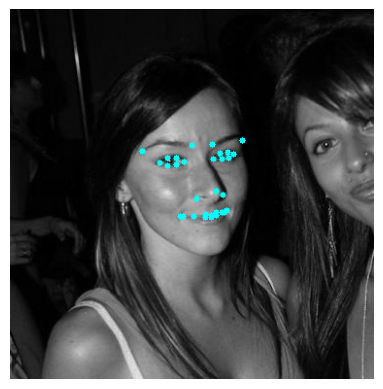

1


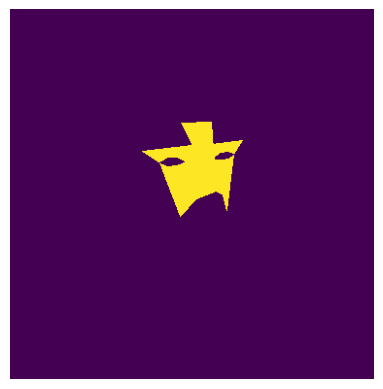

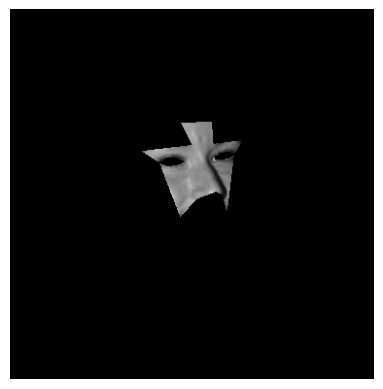

In [5]:
masked_img, selected_pts = mh.get_mask_points(IMAGE_PATH, landmarks_all_faces)
Utils.display(masked_img)

masks, masked_imgs = mh.build_masks(IMAGE_PATH, selected_pts, landmarks_all_faces)
print(len(masks))
Utils.display(masks[0])
Utils.display(masked_imgs[0])

1


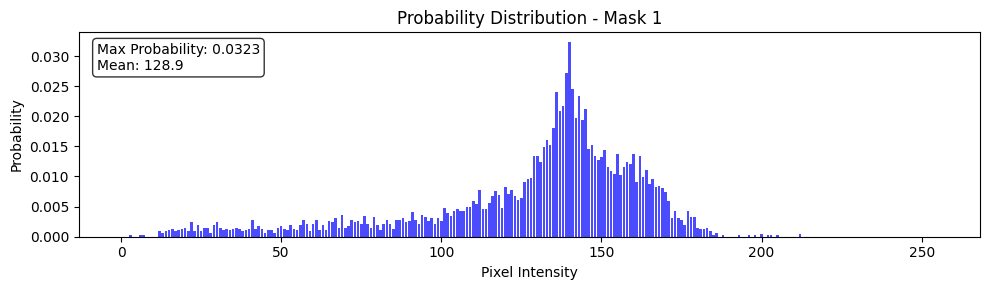

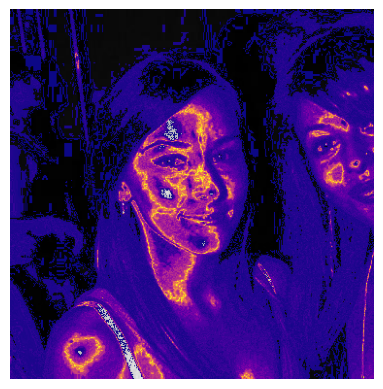

In [6]:
intensity_histograms = mh.get_intensity_histograms(IMAGE_PATH, masks)

print(len(intensity_histograms))
Utils.visualize_histograms(intensity_histograms)
Utils.apply_intensity_probability_map(IMAGE_PATH, intensity_histograms[0])

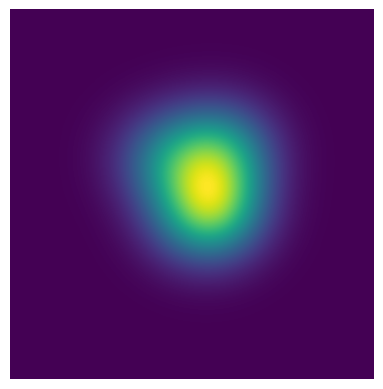

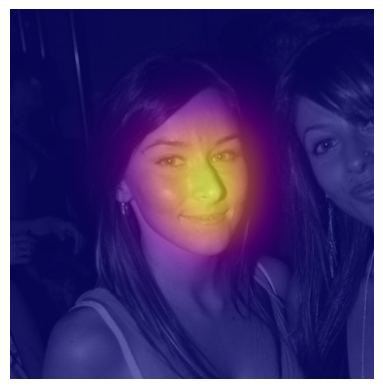

In [7]:
prior_face_masks, heatmaps, heatmaps_blended = mh.get_prior_face_masks(
    IMAGE_PATH, selected_pts
)

idx = 0
Utils.display(prior_face_masks[idx])
Utils.display(heatmaps_blended[idx])

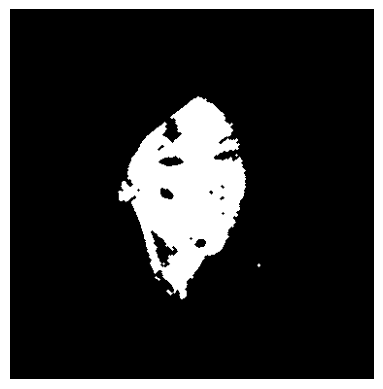

255 0


In [18]:
alpha = 0.82
lambda_ = 0.001
skin_pixel_maps = mh.get_skin_pixel_maps(
    IMAGE_PATH,
    intensity_histograms,
    prior_face_masks,
    alpha,
    lambda_,
    selected_pts,
    True,
)

skin_pixel_maps = [Utils.morphological_cleanup(s) for s in skin_pixel_maps]

idx = 0
Utils.display(skin_pixel_maps[idx], cmap="gray")
print(skin_pixel_maps[idx].max(), skin_pixel_maps[idx].min())

In [19]:
reg_size = 10
spe = SuperpixelExtractor(region_size=reg_size)
slic, contoured_img, labels, num_superpixels = spe.get_slic_superpixels(IMAGE_PATH)

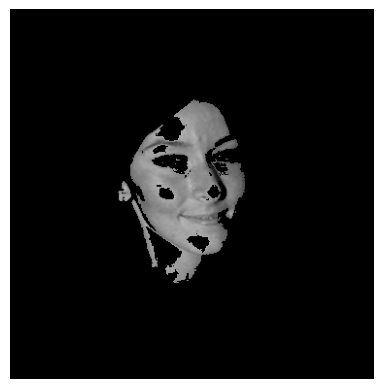

In [20]:
mask_labels = spe.get_mask_labels(slic, skin_pixel_maps[0], 0.95)
#mask_labels = spe.get_mask_labels(slic, masks[0], 0.85)
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), mask_labels)

In [21]:
fe = FeatureExtractor()
feature_vectors = fe.extract_all_features_superpixels(IMAGE_PATH, slic)

In [22]:

r = Region(
    [
        EFeature.MEAN_INTENSITY,
        EFeature.STD_INTENSITY,
        #EFeature.ENTROPY,
        EFeature.LACUNARITY_VECTOR,
    ],
)

mask_fv, non_mask_fv = r.separate_feature_vectors(feature_vectors, mask_labels)

In [23]:
most_favorable_divergences = [r.get_most_favorable_divergence(mask_fv, fv) for fv in non_mask_fv]

[351, 352, 362, 387, 391, 400, 402, 404, 422, 438, 439, 440, 441, 461, 475, 476, 477, 478, 479, 480, 511, 512, 515, 517, 538, 551, 552, 553, 569, 587, 588, 589, 591, 604, 609, 610, 613, 615, 623, 624, 625, 626, 627, 641, 661, 662, 663, 664, 665, 698, 699, 700, 716, 736, 737, 738, 775, 776, 813, 827, 828, 866, 869, 898, 903, 904, 934, 936, 938, 939, 940, 941, 976, 981, 982, 1014, 1015, 1024, 1026, 1051, 1052, 1053, 1054, 1056, 1063, 1072, 1080, 1081, 1082, 1083, 1088, 1089, 1090, 1091, 1093, 1094, 1102, 1117, 1120, 1121, 1126, 1127, 1128, 1130, 1131, 1137, 1146, 1155, 1157, 1158, 1160, 1165, 1166, 1168, 1170, 1192, 1193, 1195, 1196, 1199, 1202, 1211, 1222, 1226, 1227, 1228, 1229, 1230, 1232, 1233, 1234, 1244, 1245, 1249, 1257, 1263, 1264, 1265, 1266, 1267, 1268, 1270, 1271, 1274, 1284, 1287, 1294, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1308, 1309, 1310, 1311, 1312, 1319, 1323, 1330, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1345, 1346, 1347, 1356, 1357, 1358, 1360, 1367, 

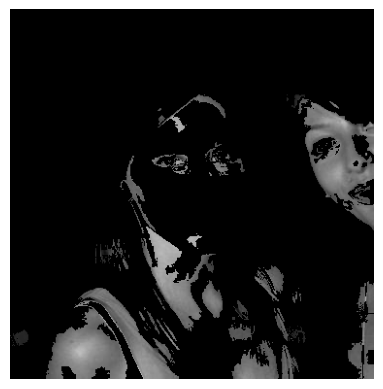

In [24]:
seeds = r.select_seed_superpixel_labels(most_favorable_divergences, 0.85)
print(seeds)
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), seeds)

In [25]:
rg_skin_superpixel_labels, rg_non_skin_superpixel_labels = r.grow(
    slic,
    seeds,
    feature_vectors,
    most_favorable_divergences,
    num_iterations=15,
    kappa=0.92
)

Grow: Size of div_map_for_non_mask: 1294
Size of div_map_for_non_mask: 1294
Kappa: 0.9200, Avg Seed Prob: 0.6233, Valid Seeds Count: 194, Calculated Threshold: 0.5734
Grow: Calculated Growth Threshold: 0.5734

--- Iteration 1/15 ---
Current skin size: 194
Found 324 candidates to evaluate this iteration.
No new skin labels added in this iteration. Stopping early.
Growth finished. Final skin labels: 194


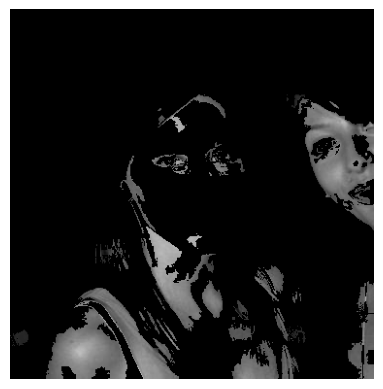

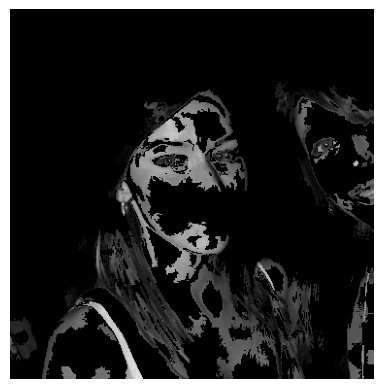

In [26]:
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), rg_skin_superpixel_labels)
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), rg_non_skin_superpixel_labels)

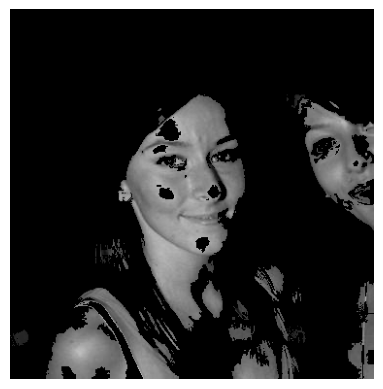

In [27]:
fin = mask_labels + rg_skin_superpixel_labels
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), fin)